# MI-ADM: home assignment 1

  * **Deadline**: 15/04/2019, -2 points for a late submission, the hard deadline is the first day of the exam period.
  * **What to submit**: Just this notebook with you code and texts, not the dataset!
  * **How to submit**: See the instructions at https://courses.fit.cvut.cz/MI-ADM/tutorials/index.html.
  
Generally speaking, the goal of this assignment is to use **decision trees and related methods (boosted trees, random forests) for the regression problem**.

What to do:
  * Study the data from `house-prices.csv` (see also `house-prices_description.txt`) and prepare them for application of the algorithms (decision tree, random forest, XGBoost).
  * Treat the missing values and nominal/ordinal variables reasonably; experiment with various approaches.
  * Try to replace the continuous features with some discrete ones (indicator variables, dummy variables, binning, ...). 
  * Tune some reasonably selected hyperparameters (using cross-validation or just a validation set) and measure the results using *Root mean squared logarithmic error (RMSLE)*.

In [1]:
import math
import pandas as pd
import numpy as np
import pydotplus
import xgboost
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn import tree
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals.six import StringIO  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image  
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import cross_validate

In [2]:
data = pd.read_csv('house-prices.csv')
# the logarithm of SalesPrice must be used to evaluate RMSLE properly
# you can comment out the following line and apply the log just before evaluating RMSLE
data.SalePrice = data.SalePrice.apply(math.log) 

## Prepare the dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Check nan values in continuous features; here I expect a bigger problem with solutions than with categorical attributes.

In [4]:
col_con = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for i in col_con:
    display(data[i].unique())

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

### Check nan values in categorical features; There nan can be proper value -> house don't have the poll for example

In [5]:
col_cat = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for i in col_cat:
    display(i + "  " + str(data[i].unique()))

"Alley  [nan 'Grvl' 'Pave']"

"MasVnrType  ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]"

"BsmtQual  ['Gd' 'TA' 'Ex' nan 'Fa']"

"BsmtCond  ['TA' 'Gd' nan 'Fa' 'Po']"

"BsmtExposure  ['No' 'Gd' 'Mn' 'Av' nan]"

"BsmtFinType1  ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']"

"BsmtFinType2  ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']"

"Electrical  ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]"

"FireplaceQu  [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']"

"GarageType  ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']"

"GarageFinish  ['RFn' 'Unf' 'Fin' nan]"

"GarageQual  ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']"

"GarageCond  ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']"

"PoolQC  [nan 'Ex' 'Fa' 'Gd']"

"Fence  [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']"

"MiscFeature  [nan 'Shed' 'Gar2' 'Othr' 'TenC']"

In the categorical attributes there nan is one of the categories in a lot of attributes. For example alley, but on the other hand, there are some attributes to repair. For example, `MasVnrType` which have None values and nan values, this can be the same values probably.

`Electrical` is the second attribute with some problem with nan. Nan is not specific in description. There is probably a house without an electrical connection between the homes being sold. I will count on this and leave it as a separate categorical when converting.

### Solve nan values

In [6]:
data.MasVnrType = data.MasVnrType.replace(np.nan, 'None')

In [7]:
# convert to categorical
data[data.select_dtypes(include=['object']).columns] = \
data.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [8]:
# can drop the id column 
data = data.drop(columns=['Id'])

Nan in continuous features will be replaced by zeros so that the decision tree can work with them, for the year of building the garage it is directly offered because not every house has a garage and 0 can represent that the garage does not. 

Another option for two remaining attributes to use for example knn, but it would be necessary first to process the dataset so that it can be used.

In [9]:
# Fill all NaN with 0
data.loc[:,data.select_dtypes(include=['float64']).columns] = \
data.loc[:,data.select_dtypes(include=['float64']).columns].fillna(0)

### Convert ordinal/categorical attributes
I try the dummy coding and the code of categorical variables.

In [10]:
data_cat_code = data.copy(deep=True)
data_cat_dummy = data.copy(deep=True)

In [11]:
# convert to code (it use -1 for nan values)
str_cols = data_cat_code.select_dtypes('category').columns
for col in str_cols:
    data_cat_code[col] = data_cat_code[col].cat.codes
data_cat_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null int8
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null int8
Alley            1460 non-null int8
LotShape         1460 non-null int8
LandContour      1460 non-null int8
Utilities        1460 non-null int8
LotConfig        1460 non-null int8
LandSlope        1460 non-null int8
Neighborhood     1460 non-null int8
Condition1       1460 non-null int8
Condition2       1460 non-null int8
BldgType         1460 non-null int8
HouseStyle       1460 non-null int8
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null int8
RoofMatl         1460 non-null int8
Exterior1st      1460 non-null int8
Exterior2nd      1460 non-null int8
MasVnrType       146

In [12]:
# Convert categorical variables to indicators and create new data 
# This generates a lot of attributes because there is a big amount of categorical attributes.
data_cat_dummy = pd.get_dummies(data_cat_dummy)
data_cat_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 289 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(4), int64(33), uint8(252)
memory usage: 781.4 KB


### Replace continuous features with some discrete ones

In [13]:
continous_cols = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']

def bin_it(bins, data, cols, res = None):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    for i in cols:
        est.fit(data[[str(i)]])
        data[str(i)] = est.transform(data[[str(i)]])
        if res == 'dummy':
            data[str(i)] = data[str(i)].astype('category')
    if res == 'dummy':
        data = pd.get_dummies(data)
    return data

In [14]:
# number of bins for variable
n_bins = 5

# categorical variables in code and continuous in dummy coding using discretization
data_cc_dummy = bin_it(5, data_cat_code.copy(deep=True), continous_cols, 'dummy')
# categorical variables in code and continuous in code of bins
data_cc_code = bin_it(10, data_cat_code.copy(deep=True), continous_cols)

# categorical variables in dummy coding and continuous in dummy coding using discretization
data_cd_dummy = bin_it(5, data_cat_dummy.copy(deep=True), continous_cols, 'dummy')

# categorical variables in dummy coding and continuous in code of bins
data_cd_code = bin_it(10, data_cat_dummy.copy(deep=True), continous_cols)

# Use dummy codding on categorical variables and unprocessed continuously attributes (prepare data)
# data_cat_code

# Use code for categorical variables and unprocessed continuously attributes (prepare data)
# data_cat_dummy

The bins have their numerical designations, which can be used for the representation for decision trees because they are represented by the number. 

To keep the bin, I will continue to write it as a code and to process this code into 1 of N as a Dummy code.

When testing a different number of bins per partition, I noticed that for the dummy coding method, there are about 5 bins optimum and about 9-10 bins for the code, where they have the best results in these numbers in different methods.

As will be seen below, with binaries, the methods are not as accurate as leaving a continuous attribute, but I expected that. However, sometimes discretization is necessary because the algorithm might not be able to work with continuous values.

## Evaluating on differently prepared datasets using multiple models (decision tree, random forests, etc...).

In [15]:
# number of cores use to evaluate cross-validation
n_jobs = -1
# numbe of fold in cross-validation
cv = 10
# scorer for crossvalidation -> minimalization RMSLE (log() was applied on the begin)
root_mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)

In [16]:
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step

In [17]:
# method for test model and iterate over one parameter, can be use only for evaluate one set of model.
def test_model_and_meta_parameter(model, data, s_params, test_param, min_value_p = 1, max_value_p = 20, step_p = 1):
    RMSLE_train = []
    RMSLE_test = []
    param_val = []
    for i in drange(min_value_p, max_value_p, step_p):
        s_params[test_param] = i
        mod = model(**s_params)
        scores = cross_validate(mod, data.drop(columns=['SalePrice']), data.SalePrice, 
                            scoring=root_mean_squared_error_scorer, cv=cv, n_jobs=n_jobs, return_train_score=True)
        param_val.append(i)
        RMSLE_test.append(np.sqrt(scores['test_score']).mean())
        RMSLE_train.append(np.sqrt(scores['train_score']).mean())
    return param_val, RMSLE_train, RMSLE_test

#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables and dummy code of categorical attributes

In [18]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cat_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cat_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 2.4405433909236118e-05, test error - 0.19842212380819843
Random forest: train error - 0.06473618869344447, test error - 0.1492925217624662
Gradient boosting tree: train error - 0.07988090764216542, test error - 0.12699471805466941
XGBoost: train error - 0.0857013415832413, test error - 0.12900066326215928


#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables and code for categorical attributes

In [19]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cat_code, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cat_code, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_code, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 2.836677465267254e-05, test error - 0.19048474149625616
Random forest: train error - 0.06512957791325254, test error - 0.1493318514499022
Gradient boosting tree: train error - 0.08097129957164763, test error - 0.12806845668989625
XGBoost: train error - 0.08682928734291508, test error - 0.1306802543831242


#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables code in dummy and code for categorical attributes

In [20]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cc_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cc_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cc_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cc_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 0.0008802525936586498, test error - 0.21473172732131257
Random forest: train error - 0.07054524070211882, test error - 0.16221735569685347
Gradient boosting tree: train error - 0.10106541815728212, test error - 0.14103006160144832
XGBoost: train error - 0.10780850855887465, test error - 0.14114268742286826


#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables code integer code and code for categorical attributes

In [21]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cc_code, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cc_code, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cc_code, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cc_code, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 2.3977193507404993e-05, test error - 0.21778785290966454
Random forest: train error - 0.06721706366185004, test error - 0.1535065031996195
Gradient boosting tree: train error - 0.09060255600289664, test error - 0.1304929368450611
XGBoost: train error - 0.09587270613987596, test error - 0.12998119487228021


#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables code in dummy and dummy coded categorical attributes

In [22]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cd_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cd_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cd_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cd_dummy, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 0.0008805623617713472, test error - 0.21854463769433616
Random forest: train error - 0.07064443931408367, test error - 0.1628024176620366
Gradient boosting tree: train error - 0.10012085279340402, test error - 0.1409341118831921
XGBoost: train error - 0.10777927524936144, test error - 0.1415107633670019


#### Test model on default parameters of methods (Decision tree, random forest, boosted tree, XGBoost) with continuous variables code integer code and dummy coded categorical attributes

In [23]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cd_code, {}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cd_code, {}, 'random_state', 1, 2, 1)[1:]
print('Random forest: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cd_code, {}, 'random_state', 1, 2, 1)[1:]
print('Gradient boosting tree: train error - ', train[0], ', test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cd_code, {}, 'random_state', 1, 2, 1)[1:]
print('XGBoost: train error - ', train[0], ', test error - ', test[0], sep='')

Decision tree: train error - 2.3598280569181105e-05, test error - 0.21100925697096962
Random forest: train error - 0.06752927378103725, test error - 0.15269604843933304
Gradient boosting tree: train error - 0.0903676314776091, test error - 0.12963431421366503
XGBoost: train error - 0.09480186824483995, test error - 0.1304964353792063


It can be seen that the decision tree without the depth limitation certainly suffers to over-learning and it is certainly necessary to limit the depth. This will be the first model and parameter I will try to improve.
 
Other models certainly have the same problem, but not so much, and the more advanced the model, the lesser the learning curve. XGBoost can already be pretty well set up so that it only suffered minimally.

With the basic parameters Gradient boosting achieved the best score. 

In the next step, I will try to debug single hyperparameters of the models and improve the results.
For each model, I will try to achieve the best score within the prepared datasets.
 
Especially in the XGBoost model, there are many parameters that can be tuned in the model.

### Tune the hyper parameters of the models

In [24]:
# Function help to plot it
def plot_it(param_val, RMSLE_train, RMSLE_test, test_param):
    fig, ax = plt.subplots()
    fig.set_size_inches(4.5, 2.5)
    ax.plot(param_val, RMSLE_train, 'rs', param_val, RMSLE_test, 'bs')
    ax.legend(['Train', 'Test'])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    plt.xlabel(test_param)
    plt.ylabel('RMSLE')
    plt.show()

#### Decision tree

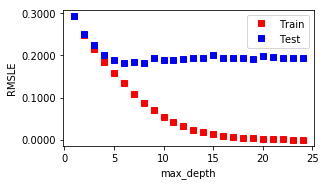

In [25]:
plot_it(*test_model_and_meta_parameter(DecisionTreeRegressor, data_cat_code, 
                                       {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1}, 
                                        'max_depth', 1, 25, 1), 'max_depth')

In [26]:
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cat_code, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: code for categorical and no for continuous. \n \
              train error - ', train[0], ',       test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cat_dummy, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: categorical in dummy and no for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cc_dummy, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':3}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: code for categorical and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cc_code, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: code for categorical and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cd_dummy, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':3}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: categorical in dummy and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(DecisionTreeRegressor, data_cd_code, {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':2}, 'random_state', 1, 2, 1)[1:]
print('Decision tree: categorical in dummy and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='') 

Decision tree: code for categorical and no for continuous. 
               train error - 0.1334527368671097,       test error - 0.1818178334158593
Decision tree: categorical in dummy and no for continuous. 
               train error - 0.13362755561229717,      test error - 0.18054719995189417
Decision tree: code for categorical and continuous in dummy code. 
               train error - 0.1565533336335046,      test error - 0.19781270039228918
Decision tree: code for categorical and code for continuous. 
               train error - 0.14354979928768064,      test error - 0.19478783656162105
Decision tree: categorical in dummy and continuous in dummy code. 
               train error - 0.15566210989421078,      test error - 0.20376837134233644
Decision tree: categorical in dummy and code for continuous. 
               train error - 0.14462254231510213,      test error - 0.19326850488067795


On the graph, the success of the decision tree depends on the depth of the decision tree.
I finally chose the depth 6 according to the cross.
I measured the model on all datasets.

The best results are if I kept the continuous attributes normal and did not combine them.

The depth was finally the main parameter, the other parameters were ideal to leave in the original settings.

#### Random forrests

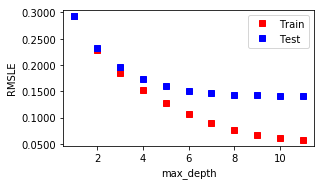

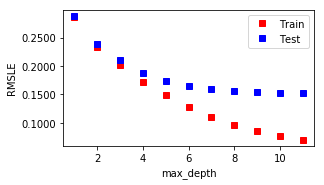

In [27]:
plot_it(*test_model_and_meta_parameter(RandomForestRegressor, data_cat_code, 
                              {'max_depth': 6, 'random_state':0, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'max_depth', 1, 12, 1), 'max_depth')
plot_it(*test_model_and_meta_parameter(RandomForestRegressor, data_cc_dummy, 
                                       {'max_depth': 6, 'random_state':0, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'max_depth', 1, 12, 1), 'max_depth')

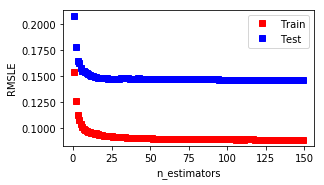

In [28]:
plot_it(*test_model_and_meta_parameter(RandomForestRegressor, data_cat_code, 
                                       {'max_depth': 7, 'random_state':0, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'n_estimators', 1, 150, 1), 'n_estimators')

In [29]:
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cat_code,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: code for categorical and no for continuous. \n \
              train error - ', train[0], ',       test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cat_dummy,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: categorical in dummy and no for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cc_dummy,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: code for categorical and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cc_code,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: code for categorical and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cd_dummy,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: categorical in dummy and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(RandomForestRegressor, data_cd_code,  {'max_depth': 6, 'random_state':1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':180}, 'random_state', 1, 2, 1)[1:]
print('Random forest: categorical in dummy and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='') 

Random forest: code for categorical and no for continuous. 
               train error - 0.10614124166271555,       test error - 0.15130229911145818
Random forest: categorical in dummy and no for continuous. 
               train error - 0.1066302260090732,      test error - 0.15220958853809408
Random forest: code for categorical and continuous in dummy code. 
               train error - 0.12815598381496338,      test error - 0.16554671430277942
Random forest: code for categorical and code for continuous. 
               train error - 0.11837621747927507,      test error - 0.15767939417297042
Random forest: categorical in dummy and continuous in dummy code. 
               train error - 0.1277268953556578,      test error - 0.16536453915027854
Random forest: categorical in dummy and code for continuous. 
               train error - 0.11867407669217933,      test error - 0.1579760537685988


The random forest parameters behaved as expected. I chose the depth again 6. This method has achieved significantly better results than the tree itself.

Here, the datasets, where I left continuous attributes unbound, also came close to a dataset, where I used dummy coding for categorical attributes and continually binned into ten bins and used the generated representation for each bin.

#### Gradient boosting

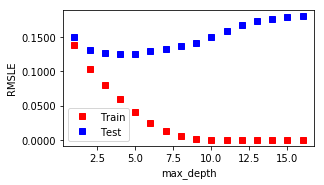

In [30]:
plot_it(*test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_code, 
                                      {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'max_depth', 1, 17, 1), 'max_depth')

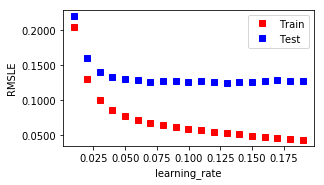

In [31]:
plot_it(*test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_code, 
                                       {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'learning_rate', 0.01, 0.2, 0.01), 'learning_rate')

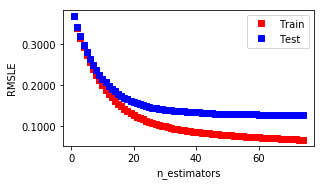

In [32]:
plot_it(*test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_code, 
                                       {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':100}, 
                                        'n_estimators', 1, 75, 1), 'n_estimators')

In [33]:
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_code, {'max_depth': 4, 'random_state':0, 'learning_rate':0.1,
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: code for categorical and no for continuous. \n \
              train error - ', train[0], ',       test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cat_dummy,  {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: categorical in dummy and no for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cc_dummy,  {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: code for categorical and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cc_code,  {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: code for categorical and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cd_dummy,  {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: categorical in dummy and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(GradientBoostingRegressor, data_cd_code,  {'max_depth': 4, 'random_state':0, 'learning_rate':0.1, 
                                        'min_samples_split':2, 'min_samples_leaf':1, 'n_estimators':75}, 
                                        'random_state', 1, 2, 1)[1:]
print('Gradient boosting: categorical in dummy and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='') 

Gradient boosting: code for categorical and no for continuous. 
               train error - 0.06666079608909234,       test error - 0.12654736625315172
Gradient boosting: categorical in dummy and no for continuous. 
               train error - 0.06632966509081449,      test error - 0.1266040425763933
Gradient boosting: code for categorical and continuous in dummy code. 
               train error - 0.08571531469844,      test error - 0.13986662739376282
Gradient boosting: code for categorical and code for continuous. 
               train error - 0.07774163226752738,      test error - 0.13183123782404613
Gradient boosting: categorical in dummy and continuous in dummy code. 
               train error - 0.08623904116367734,      test error - 0.13840793631859688
Gradient boosting: categorical in dummy and code for continuous. 
               train error - 0.07802866653586708,      test error - 0.13237564440982302


The boosted tree also had the parameter learning rate. With this method, I chose a smaller depth of trees for over-fitting, which was evident in this method at great depth. Also, the learning rate remained lower to avoid such over-fitting.

Again, this method achieved better results than the previous one, and it was best to leave continuous parameters untouched. The difference was even more pronounced than previous methods.

#### XGBoost

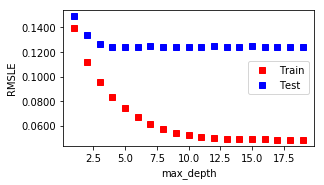

In [34]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                      {'colsample_bytree': 0.5, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':3, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'max_depth', 1, 20, 1), 'max_depth')

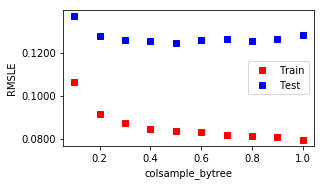

In [35]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'colsample_bytree', 0.1, 1, 0.1), 'colsample_bytree')

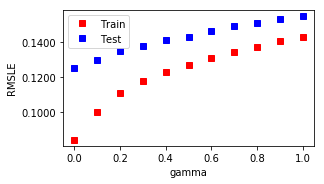

In [36]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'gamma', 0, 1, 0.1), 'gamma')

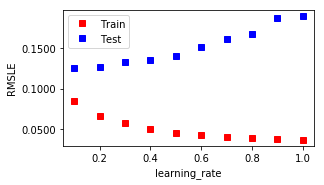

In [37]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'learning_rate', 0.1, 1, 0.1), 'learning_rate')

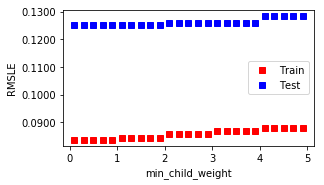

In [38]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'min_child_weight', 0.1, 5, 0.2), 'min_child_weight')

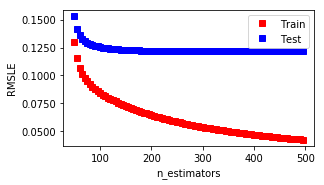

In [39]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'n_estimators', 50, 500, 5), 'n_estimators')

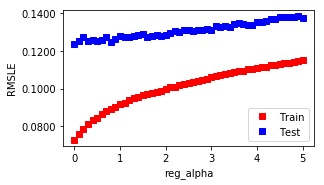

In [40]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'reg_alpha', 0, 5, 0.1), 'reg_alpha')

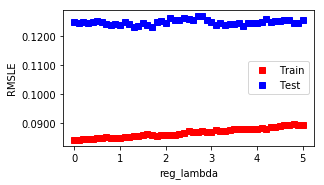

In [41]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'reg_lambda', 0, 5, 0.1), 'reg_lambda')

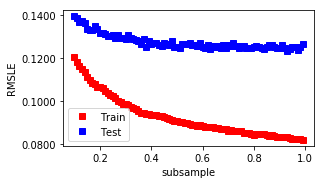

In [42]:
plot_it(*test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, 
                                       {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 
                                        'subsample', 0.1, 1, 0.01), 'subsample')

In [43]:
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_code, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':10000,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: code for categorical and no for continuous. \n \
              train error - ', train[0], ',       test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cat_dummy, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: categorical in dummy and no for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cc_dummy, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: code for categorical and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cc_code, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: code for categorical and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cd_dummy, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: categorical in dummy and continuous in dummy code. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='')
train, test = test_model_and_meta_parameter(xgboost.XGBRegressor, data_cd_code, {'colsample_bytree': 0.4, 'gamma':0, 'learning_rate':0.1, 
                                        'max_depth':4, 'min_child_weight':1.5, 'n_estimators':100,
                                        'reg_alpha':0.5, 'reg_lambda':0.45, 'subsample':0.8, 
                                        'seed':42}, 'seed', 42, 43, 1)[1:]
print('XGBoost: categorical in dummy and code for continuous. \n \
              train error - ', train[0], ',      test error - ', test[0], sep='') 

XGBoost: code for categorical and no for continuous. 
               train error - 0.017298075388074676,       test error - 0.12354150601561764
XGBoost: categorical in dummy and no for continuous. 
               train error - 0.08608964233041166,      test error - 0.12557509768761527
XGBoost: code for categorical and continuous in dummy code. 
               train error - 0.10456057348519136,      test error - 0.1381382386315992
XGBoost: code for categorical and code for continuous. 
               train error - 0.09357458097851681,      test error - 0.12855730965738763
XGBoost: categorical in dummy and continuous in dummy code. 
               train error - 0.10565172166973813,      test error - 0.13997466621358123
XGBoost: categorical in dummy and code for continuous. 
               train error - 0.09469943341302785,      test error - 0.12687528975661094


With XGBoost I managed to achieve the best results, this method had the slightest tendency to over-fitting and even with the wrongly selected parameters did not drop significantly test error.

Also, the results did not improve so much against the basic parameters that are set. In this method, datasets without binaries again had the best result, but using the dummy code for categorical attributes and binning to 10 bins was quite successful. 

In the preprocessing of continuous attributes, in this test, the bins did not work in the dummy code, but it is better to leave them in numerical representation as they were divided. This division and the near bins as numbers seem to retain the information better.

On the contrary, it is not very important for categorical ones, and it is better to use the dummy code.